Цель дипломной работы: построить регрессию зависимость ЗП в области Data Science от факторов: (знаний, опыта,
места работы и т.д.) 

Этапы:
1. Сбор данных hh.ru, ods.ai, indeed.com (включая архив)
2. Приведение к одному формату
3. Анализ
4. Предобработка
5. Построение модели
6. Выводы

In [2]:
import urllib.request
import json
import re
import pandas as pd
from tqdm import tqdm
import time

#https://nahabino.hh.ru/search/vacancy?text=Data+scientist&area=1&salary=&currency_code=RUR&experience=doesNotMatter&order_by=relevance&search_period=&items_on_page=20&no_magic=true&from=suggest_post
https://nahabino.hh.ru/search/vacancy?text=Data+scientist
    &area=1
    &salary=
    &currency_code=RUR
    &experience=doesNotMatter
    &order_by=relevance
    &search_period=
    &items_on_page=20
    &no_magic=true
    &from=suggest_post

In [ ]:
&archived=true

In [ ]:
машинное обучение, Machine learning, data engineer, 

In [3]:
#Modified
per_page = 20
page = 100
specialization = 1

request = urllib.request.Request("https://api.hh.ru/areas")
response = urllib.request.urlopen(request)
response = json.loads(response.read().decode('utf-8'))
response = [d for d in response if d['id'] == '113'][0]['areas']
area_dict = {int(d["id"]): d['name'] for d in response}
docs = []
for j in tqdm(area_dict.keys()):
    for i in range(page):
        # поиск вакансий в регионе с заданой специализацией
        request = urllib.request.Request("https://api.hh.ru/vacancies?area=" + str(j) + \
                                         "&text=Data+scientist="  +
                                         #&specialization=" + str(specialization) +
                                         "&only_with_salary=true" + "&per_page=" + str(per_page) \
                                         + '&page=' + str(i))
        response = urllib.request.urlopen(request)
        data = json.loads(response.read().decode('utf-8'))['items']
        for v, d in enumerate(data):
            time.sleep(1.0)
            request = urllib.request.Request("https://api.hh.ru/vacancies/{}".format(d['id']))
            response = urllib.request.urlopen(request)
            full = json.loads(response.read().decode('utf-8'))
            d['description'] = full['description']
            d['experience'] = full['experience']['id']
            if d['address']:
                d['region'] = {'city': d['address']['city'], 'lat': d['address']['lat'], 'lng': d['address']['lng']}
            if not d.get('region', None):
                d['region'] = {'city': area_dict[j], 'lat': None, 'lng': None}
            d['area'] = area_dict[j]
            docs.append(d)

docs = set([json.dumps(d) for d in docs])
docs = [json.loads(d) for d in docs]



100%|██████████| 84/84 [16:14<00:00, 10.75s/it]


In [12]:
i=0
for d in docs:
    i+=1
i

62

In [13]:
def process_salary(salary):
    if salary['to'] and salary['from']:
        sal = (salary['from'] + salary['to']) / 2.
    elif salary['to']:
        sal = salary['to']
    else:
        sal = salary['from']
    if salary['gross']:
        sal *= 0.87
    if salary['currency'] == 'EUR':
        sal *= 75.99
    elif salary['currency'] == 'USD':
        sal *= 65.57
    return sal

#def process_tech(text):
#    tech_dict = {key: 0 for key in regexs.keys()}
#    for key, reg in regexs.items():
#        search = reg.search(text)
#        if search:
#            tech_dict[key] = 1
#    return tech_dict


#techs_case = ['C', 'R']
#techs = ['javascript', 'sql', 'java', 'c#', 'PHP', 'Python', 'C++', 'Swift', 'ruby', 'go', 'typescript', 'scala',
#         'objective-c', 'kotlin', 'pl-sql', 'pascal', 'delphi', 'perl', 'clojure', 'swift', 'vb .net', 'groovy',
#         'lua', 'haskell', 'hibernate', 'spring', 'tensorflow', 'keras', 'caffe', 'theano', 'matlab', 'angular',
#         'ruby on rails', 'yii', 'django', 'flask', 'asp', 'knockout', 'bootstrap', 'html', 'css', 'vue',
#         'pytorch', 'cuda', 'react', 'meteor', 'jsf', 'laravel', 'node', 'networkx', 'matplotlib', 'plotly',
#         'beautifulsoup']


#regexs = {tech: re.compile(r"\s+"+re.escape(tech)+r"(\s+|\.|,|;)") for tech in techs_case}
#regexs.update({tech: re.compile(r"\s+"+re.escape(tech)+r"(\s+|\.|,|;)", flags=re.IGNORECASE) for tech in techs})
#regexs['1С'] = re.compile(r"\s+(1С|1C)-?"+r"(\s+|\.|,|;)", flags=re.IGNORECASE)

second_docs = []
for i, doc in enumerate(tqdm(docs)):
    if doc['salary']:
        out_doc = {}
        out_doc['id'] = i
        out_doc['title'] = doc['name']
        out_doc['employer'] = doc['employer']['name']
        out_doc['salary'] = process_salary(doc['salary'])
        out_doc['description'] = doc['description']    # description in html format
        #current_techs = process_tech(out_doc['description'])
        out_doc['city'], out_doc['lat'], out_doc['lng'] = doc['region']['city'], doc['region']['lat'],\
                                                          doc['region']['lng']
        out_doc['experience'] = doc['experience']
        out_doc['area'] = doc['area']
        #if any(list(current_techs.values())):
        #    second_docs.append({**out_doc, **current_techs})
        second_docs.append(out_doc)

data = pd.DataFrame(second_docs)
data.to_csv('hh_dataset.csv')

100%|██████████| 62/62 [00:00<00:00, 141253.04it/s]


In [17]:
#df=pd.read_csv('hh_dataset.csv')
#df.head()
#data
data[['area', 'title', 'city', 'description', 'employer', 'salary', 'lat', 'lng', 'experience']].head()

,area,title,city,description,employer,salary,lat,lng,experience
0,Москва,Архитектор решений (IT/IoT/автоматизация),Москва,<p>Международный холдинг Tibbo - ведущий произ...,Tibbo,87000.0,NaN,NaN,between1And3
1,Москва,"Ведущий специалист / data scientist (big data,...",Москва,"<p>IT-компании, специализирующейся в области d...",Прогностические решения,150000.0,55.762556,37.627175,between3And6
2,Санкт-Петербург,Маркетолог-аналитик / Data Scientist,None,<p><strong>Центр образовательных технологий Ad...,Центр образовательных технологий Николая Ягодк...,60000.0,NaN,NaN,between1And3
3,Новосибирская область,Data scientist (Machine Learning Engineer),Новосибирск,<p>Всем привет!<br /><br />Мы - команда корпор...,Dialog,100000.0,54.858025,83.110567,between1And3
4,Москва,Аналитик данных (Data Scientist),Москва,<p><strong>Агентство Мерчендайзинга &quot;Прем...,Премьер Аналитика,150000.0,55.818882,37.618893,between3And6


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 10 columns):
area           62 non-null object
city           57 non-null object
description    62 non-null object
employer       62 non-null object
experience     62 non-null object
id             62 non-null int64
lat            33 non-null float64
lng            33 non-null float64
salary         62 non-null float64
title          62 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 4.9+ KB


In [31]:
data['salary'].describe()

count        62.000000
mean     143418.158871
std       63655.990105
min       25000.000000
25%      100000.000000
50%      148950.000000
75%      180000.000000
max      300000.000000
Name: salary, dtype: float64

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

(array([ 8., 17., 18.,  7., 10.,  2.]),
 array([ 25000.        ,  70833.33333333, 116666.66666667, 162500.        ,
        208333.33333333, 254166.66666667, 300000.        ]),
 <a list of 6 Patch objects>)

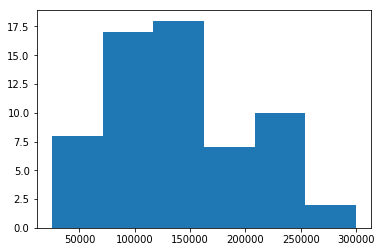

In [54]:
#plt.hist(data['experience'])
plt.hist(data['salary'], bins=6)

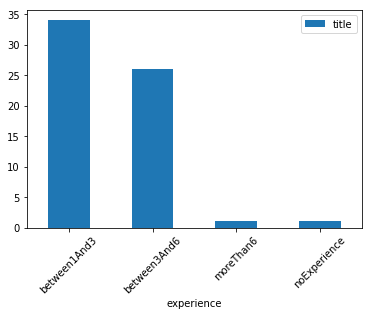

In [49]:
by_experience=data.pivot_table(index = 'experience', \
                               #columns = 'student_netology', \
                       values = 'title', aggfunc = 'count', fill_value = 0)
by_experience.plot(kind='bar', rot=45)

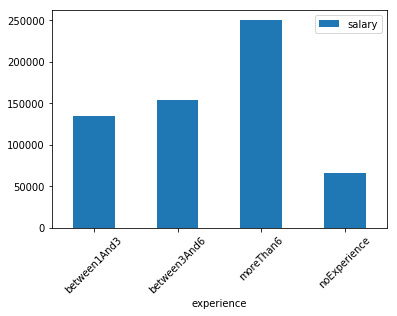

In [51]:
by_experience_with_sal=data.pivot_table(index = 'experience', \
                               #columns = 'student_netology', \
                       values = 'salary', aggfunc = 'mean', fill_value = 0)
by_experience_with_sal.plot(kind='bar', rot=45)

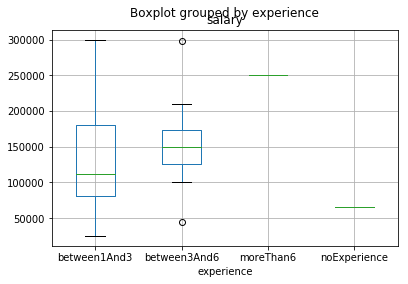

In [57]:
data.boxplot(column='salary', by='experience', ax=None, \
            # fontsize=None, rot=0, grid=True, figsize=None, layout=None, return_type=None, **kwds\
            )